<a href="https://colab.research.google.com/github/VasylDvorakDS/Titanic_project_victims_prediction/blob/master/Titanic_project_victims_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [370]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBRFClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [371]:
df_train =pd.read_csv("train.csv")
df_test =pd.read_csv("test.csv")
display(df_train.head())
display(df_test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [372]:
pd.DataFrame(data=[df_train.isna().sum()/df_train.shape[0]*100, df_test.isna().sum()/df_test.shape[0]*100], index=['Train Null (%)', 'Test Null (%)']).T.style.background_gradient(cmap='summer_r')

,Train Null (%),Test Null (%)
PassengerId,0.000000,0.000000
Survived,0.000000,nan
Pclass,0.000000,0.000000
Name,0.000000,0.000000
Sex,0.000000,0.000000
Age,19.865320,20.574163
SibSp,0.000000,0.000000
Parch,0.000000,0.000000
Ticket,0.000000,0.000000
Fare,0.000000,0.239234


In [373]:
print (f"Train data has {df_train.duplicated().sum()} duplicated data")
print (f"Test data has {df_test.duplicated().sum()} duplicated data")

Train data has 0 duplicated data
Test data has 0 duplicated data


In [374]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [375]:
num_var = ['SibSp', 'Parch', 'Age', 'Fare']
cat_var = ['Sex','Embarked','Pclass']
target = 'Survived'

In [376]:
def num_dist(data, var):
  fig, ax = plt.subplots(1,2, figsize=(12,4))

  sns.histplot(data=data, x=var, kde=True, ax=ax[0])
  sns.boxplot(data=data, x=var, ax=ax[1])
  ax[0].set_title(f'{var} Distribution Histogram')
  ax[1].set_title(f'{var} Distribution Boxplot')

  plt.show()


def cat_dist(data, var):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))

    # Pie chart
    data[var].value_counts().plot(kind='pie',
                                  explode=[0.05 for x in data[var].dropna().unique()],
                                  autopct='%1.1f%%',
                                  ax=ax[0])
    ax[0].set_title(f'{var} Pie Chart')
    ax[0].set_ylabel('')

    # Bar chart
    count = sns.countplot(x=var, data=df_train, ax=ax[1])

    # Annotating the bar chart with values
    for bar in count.patches:
        count.annotate(format(bar.get_height()),
                       (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                       ha='center', va='center',
                       size=11, xytext=(0, 8),
                       textcoords='offset points')

    ax[1].set_title(f'{var} Bar Chart')
    plt.show()




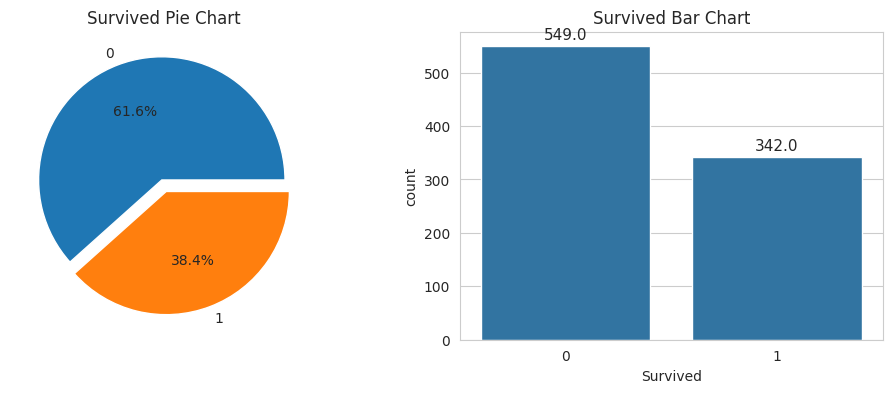

In [377]:
cat_dist(df_train, 'Survived')

In [378]:
df_train[num_var].describe()

,SibSp,Parch,Age,Fare
count,891.000000,891.000000,714.000000,891.000000
mean,0.523008,0.381594,29.699118,32.204208
std,1.102743,0.806057,14.526497,49.693429
min,0.000000,0.000000,0.420000,0.000000
25%,0.000000,0.000000,20.125000,7.910400
50%,0.000000,0.000000,28.000000,14.454200
75%,1.000000,0.000000,38.000000,31.000000
max,8.000000,6.000000,80.000000,512.329200


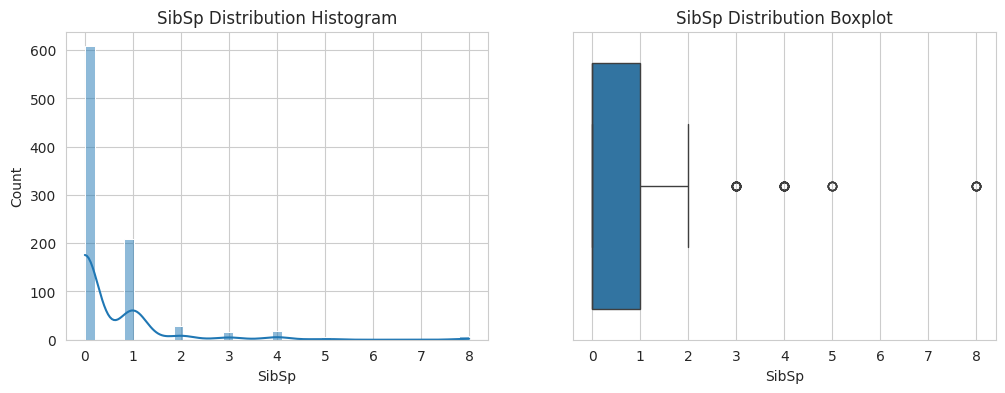

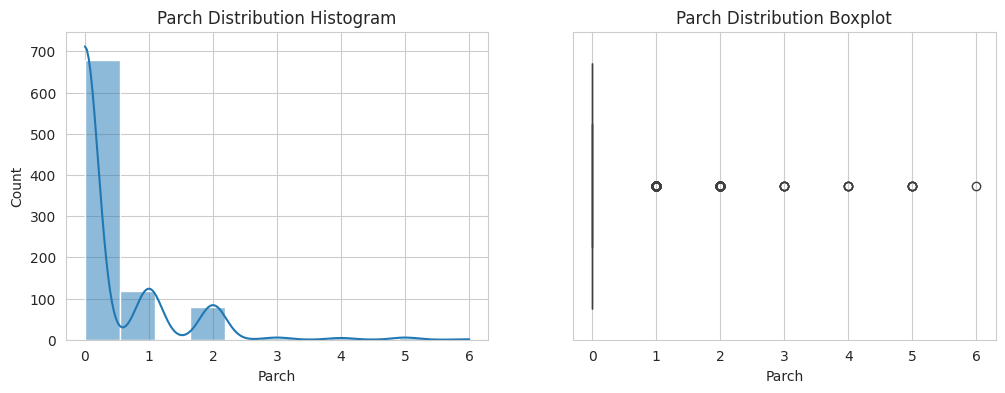

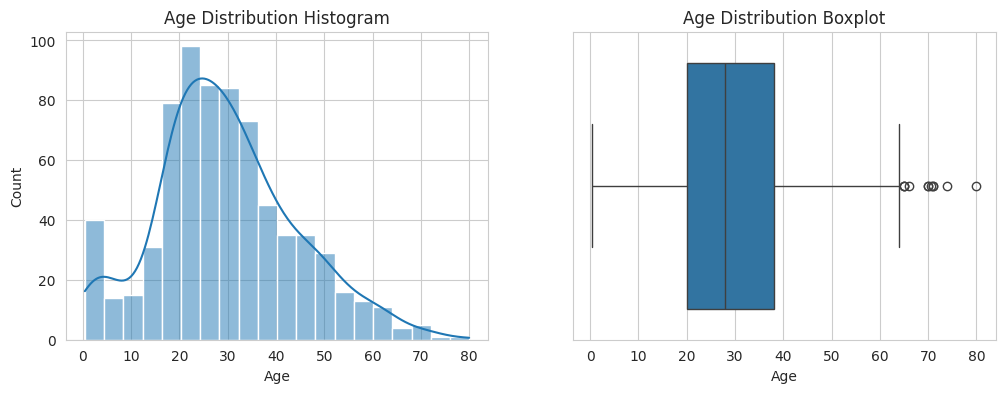

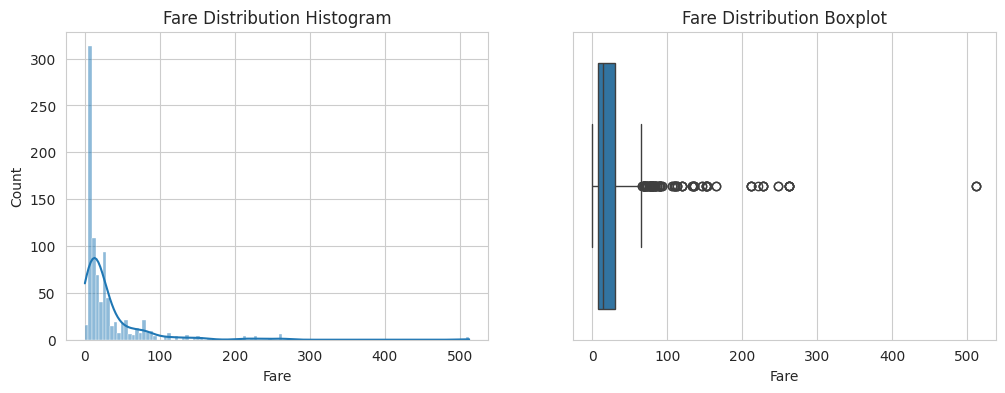

In [379]:
for var in num_var:
  num_dist(df_train, var)

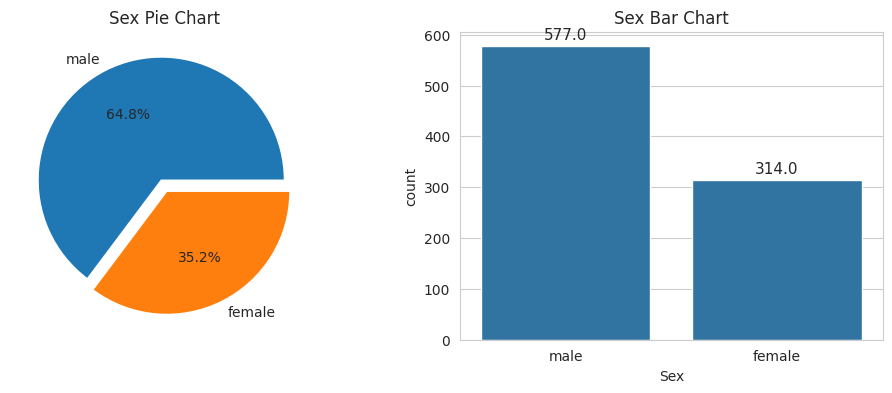

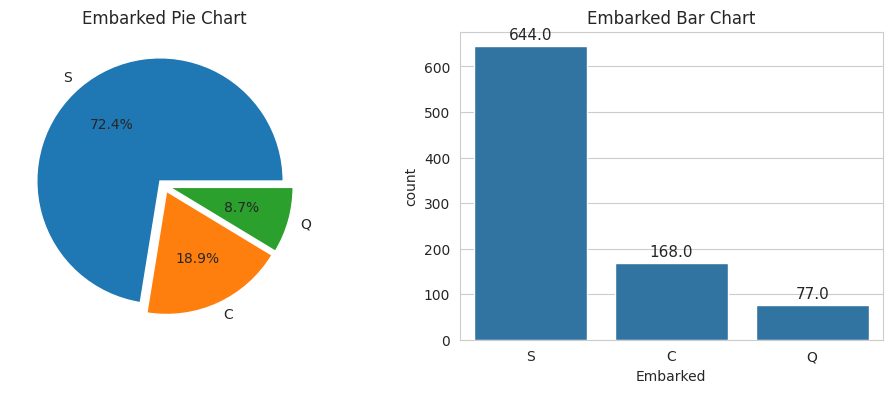

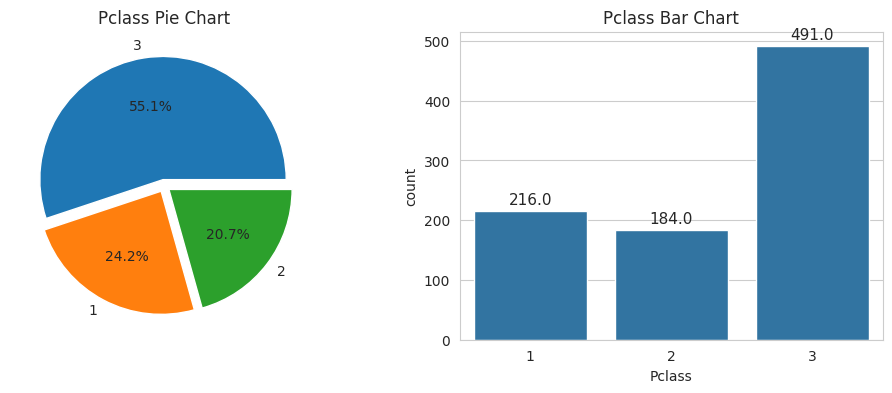

In [380]:
for var in cat_var:
  cat_dist(df_train, var)

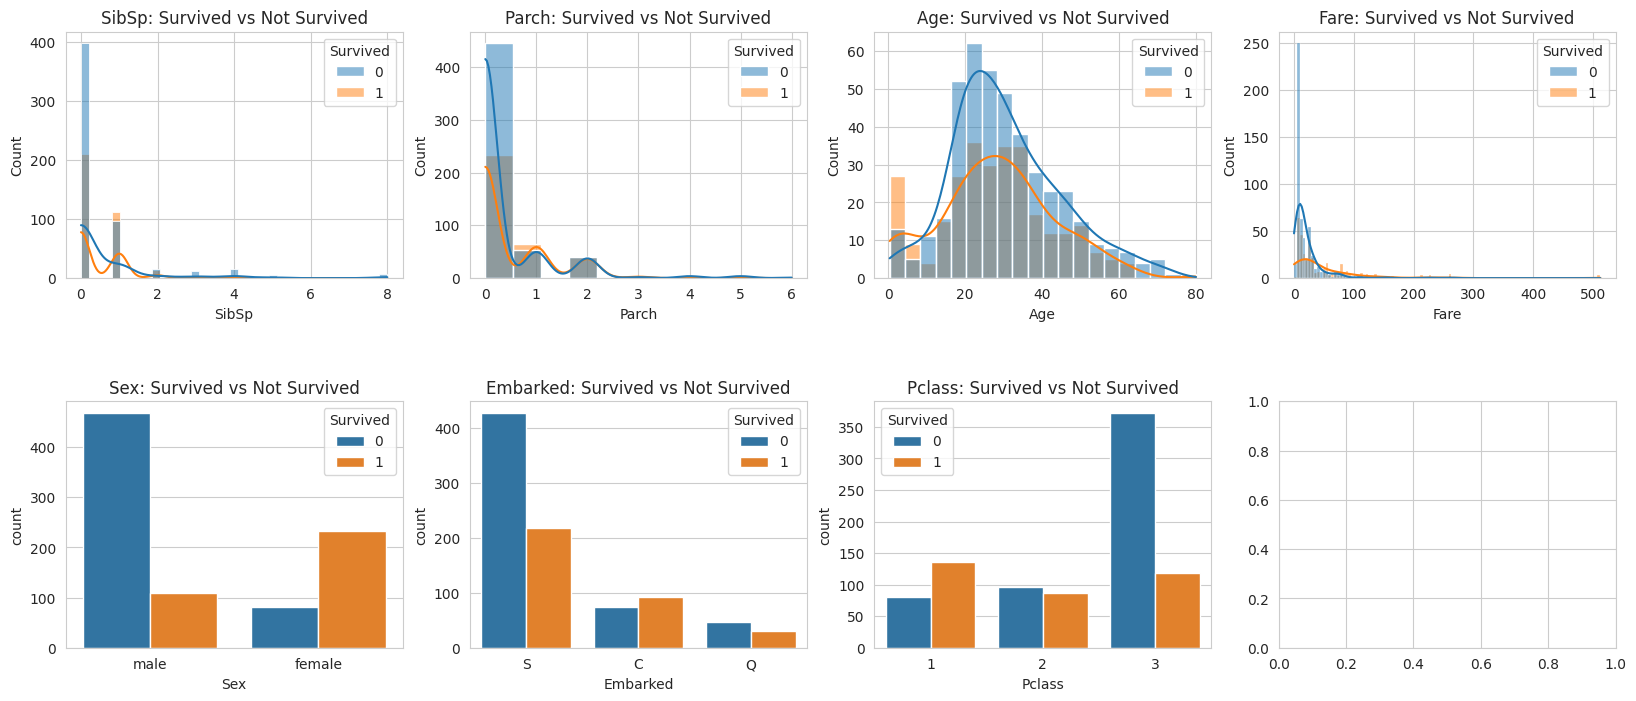

In [381]:
fig, ax = plt.subplots(2,4, figsize=(20,8))
ax=ax.flatten()

for i, var in enumerate(num_var+cat_var):
  if i < 4:
    sns.histplot(data=df_train, x=var, hue =target, kde=True, ax=ax[i])
  else:
    sns.countplot(data=df_train, x=var, hue =target, ax=ax[i])

  ax[i].set_title(f'{var}: Survived vs Not Survived')

plt.subplots_adjust(hspace=0.5)
plt.show()

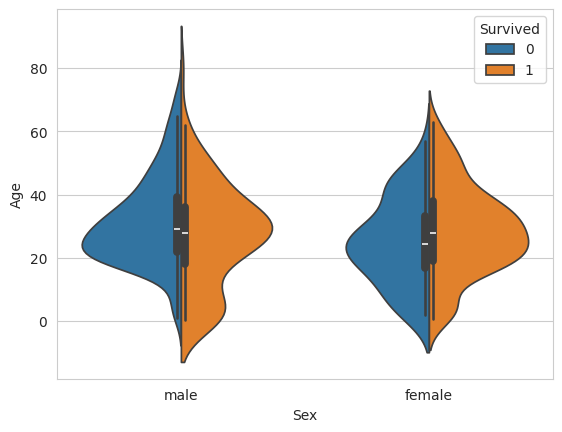

In [382]:
sns.violinplot(data=df_train, x='Sex', y="Age", hue='Survived', split=True)
plt.show()

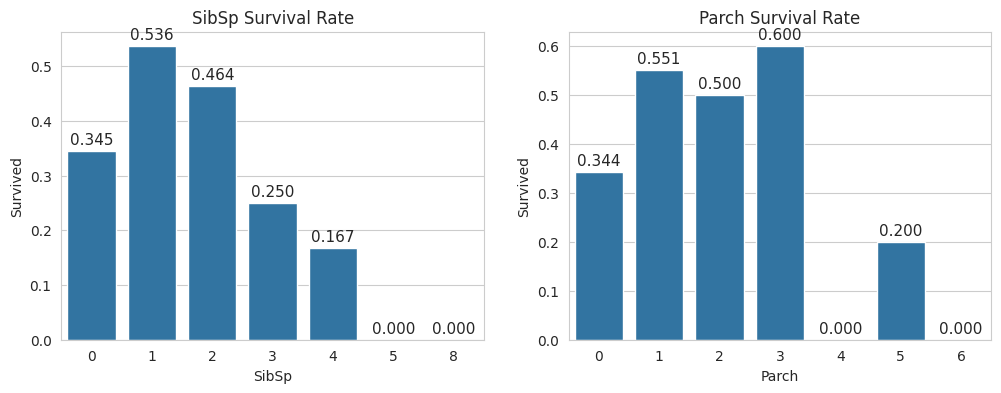

In [383]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

for i, var in enumerate(['SibSp', 'Parch']):
  surv = sns.barplot(data=df_train, x=var, y=target, ax=ax[i], ci=None)
  for bar in surv.patches:
    surv.annotate(format('{:.3f}'.format(bar.get_height())),
                  (bar.get_x()+bar.get_width()/2,
                   bar.get_height()), ha ='center', va='center',
                  size=11, xytext=(0,8),
                  textcoords='offset points')

  ax[i].set_title(f'{var} Survival Rate')

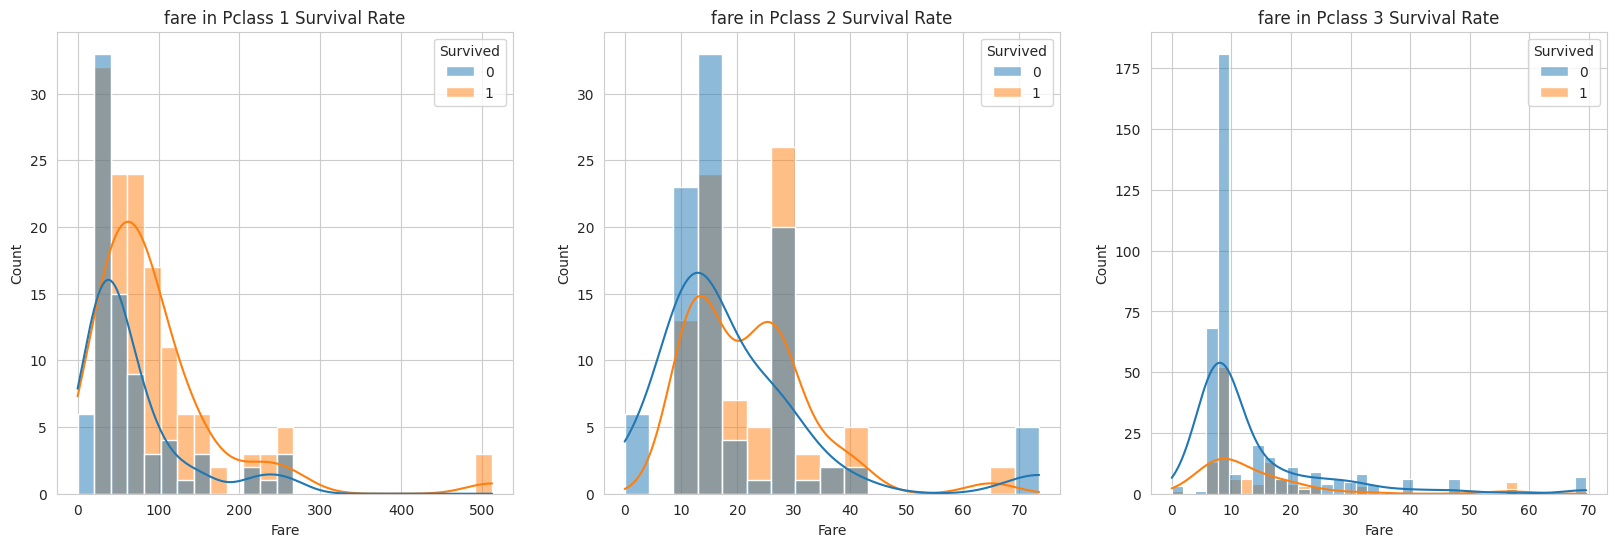

In [384]:
fig, ax =plt.subplots(1,3, figsize=(20,6))

for i, pc in enumerate(sorted(df_train['Pclass'].unique())):
  sns.histplot(data=df_train[df_train['Pclass']==pc], x='Fare', hue =target, kde=True, ax=ax[i])
  ax[i].set_title(f'fare in Pclass {pc} Survival Rate')

In [385]:
df_train['PassengerId']

,PassengerId
0,1
1,2
2,3
3,4
4,5
...,...
886,887
887,888
888,889
889,890


In [386]:
df_train.drop('PassengerId', axis=1,inplace=True)
df_test.drop('PassengerId', axis=1,inplace=True)

In [387]:
df_train['Name']

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"
...,...
886,"Montvila, Rev. Juozas"
887,"Graham, Miss. Margaret Edith"
888,"Johnston, Miss. Catherine Helen ""Carrie"""
889,"Behr, Mr. Karl Howell"


In [388]:
df_train['Title'] = df_train['Name'].str.extract('([A-Za-z]+)\.')
df_test['Title'] = df_test['Name'].str.extract('([A-Za-z]+)\.')
df_train['Title'].value_counts()

,count
Title,
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Mlle,2
Major,2
Col,2


In [389]:
def convert_title(title):
  if title in ['Ms', 'Mile', 'Miss']:
    return 'Miss'
  elif title in ['Mme', 'Mrs']:
    return 'Mrs'
  elif title == 'Mr':
    return 'Mr'
  elif title == 'Master':
    return 'Master'
  else:
    return 'Other'

df_train['Title']=df_train['Title'].map(convert_title)
df_test['Title'] = df_test['Title'].map(convert_title)

df_train['Title'].value_counts()


,count
Title,
Mr,517
Miss,183
Mrs,126
Master,40
Other,25


In [390]:
df_train.drop('Name', axis=1, inplace=True)
df_test.drop('Name', axis=1, inplace=True)


In [391]:
df_train['Ticket']

,Ticket
0,A/5 21171
1,PC 17599
2,STON/O2. 3101282
3,113803
4,373450
...,...
886,211536
887,112053
888,W./C. 6607
889,111369


In [392]:
df_train.drop('Ticket', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)

In [393]:
df_train.drop('Cabin', axis=1, inplace=True)
df_test.drop('Cabin', axis=1, inplace=True)

In [394]:
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Other
887,1,1,female,19.0,0,0,30.0000,S,Miss
888,0,3,female,NaN,1,2,23.4500,S,Miss
889,1,1,male,26.0,0,0,30.0000,C,Mr


In [395]:
df_train.drop(['Sex', 'Embarked','Title'], axis=1).corr()['Age'].sort_values(ascending=True)

,Age
Pclass,-0.369226
SibSp,-0.308247
Parch,-0.189119
Survived,-0.077221
Fare,0.096067
Age,1.000000


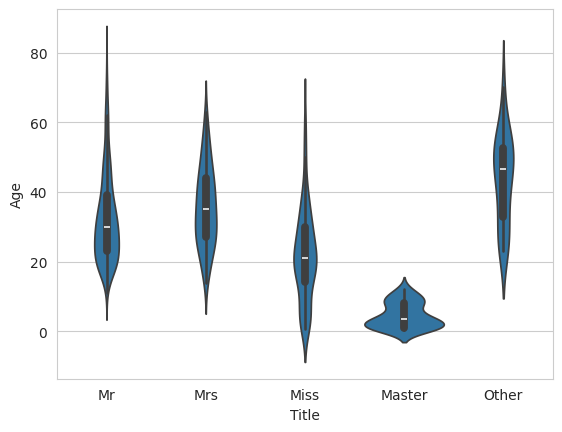

In [396]:
sns.violinplot(data=df_train, x='Title', y='Age');

In [397]:
df_train.groupby('Title')['Age'].mean()

,Age
Title,
Master,4.574167
Miss,21.816327
Mr,32.368090
Mrs,35.788991
Other,43.750000


In [398]:
data =[df_train, df_test]
for df in data:
  df.loc[(df['Age'].isnull()) & (df['Title']=='Master'), 'Age'] =5
  df.loc[(df['Age'].isnull()) & (df['Title']=='Miss'), 'Age'] =22
  df.loc[(df['Age'].isnull()) & (df['Title']=='Mr'), 'Age'] =32
  df.loc[(df['Age'].isnull()) & (df['Title']=='Mrs'), 'Age'] =36
  df.loc[(df['Age'].isnull()) & (df['Title']=='Other'), 'Age'] =36

In [399]:
df_train.drop(['Sex', 'Embarked','Title'], axis=1).corr()['Fare'].sort_values(ascending=False)


,Fare
Fare,1.000000
Survived,0.257307
Parch,0.216225
SibSp,0.159651
Age,0.092069
Pclass,-0.549500


In [400]:
df_test[df_test['Fare'].isna()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
152,3,male,60.5,0,0,NaN,S,Mr


In [401]:
df_test.Fare.fillna(df_test.Fare.mean(), inplace=True)

In [402]:
data =[df_train, df_test]
for df in data:
  df['Relatives'] = df['SibSp']+df['Parch']
  df.loc[df['Relatives']>0, 'Alone']=1
  df.loc[df['Relatives']==0, 'Alone']=0

In [403]:
df_train.drop(['SibSp', 'Parch'], axis=1, inplace=True)
df_test.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [404]:
df_train = pd.get_dummies(df_train, prefix=['Sex', 'Embarked', 'Title'])
df_test = pd.get_dummies(df_test, prefix=['Sex', 'Embarked', 'Title'])

In [405]:
X_train=df_train.drop('Survived', axis=1)
y_train=df_train.Survived
X_test=df_test.copy()

In [406]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


In [407]:
classifiers ={
    'KNN': KNeighborsClassifier(),
    'LR': LogisticRegression(max_iter=1000),
    'DT': DecisionTreeClassifier(),
    'RF': RandomForestClassifier(),
    'SVM': SVC(),
    'MLP': MLPClassifier(max_iter=1000),
    'XGB': XGBClassifier(),
    'LGBM': LGBMClassifier()
}

results =pd.DataFrame(columns=['Classifier', 'Avg_Accuracy', 'Avg_F1_Score'])
for name,clf in classifiers.items():
  model = clf
  cv_results=cross_validate(
      model, X_train_scaled, y_train, cv=10,
      scoring=(['accuracy', 'f1']))

# Create a new DataFrame for the new row
  new_row = pd.DataFrame({
    'Classifier': [name],
    'Avg_Accuracy': [cv_results['test_accuracy'].mean()],
    'Avg_F1_Score': [cv_results['test_f1'].mean()]
})

# Concatenate the new row to the results DataFrame
  results = pd.concat([results, new_row], ignore_index=True)

results['Avg_Overall'] = (results['Avg_Accuracy'] + results['Avg_F1_Score']) / 2
results=results.sort_values('Avg_Overall', ascending=False)
results

[LightGBM] [Info] Number of positive: 307, number of negative: 494
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 801, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383271 -> initscore=-0.475688
[LightGBM] [Info] Start training from score -0.475688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,Classifier,Avg_Accuracy,Avg_F1_Score,Avg_Overall
1,LR,0.829413,0.768237,0.798825
7,LGBM,0.823820,0.761581,0.792700
6,XGB,0.819338,0.757723,0.788531
4,SVM,0.822697,0.747500,0.785098
0,KNN,0.819388,0.745880,0.782634
5,MLP,0.819363,0.742867,0.781115
3,RF,0.810375,0.745658,0.778016
2,DT,0.778926,0.711009,0.744968


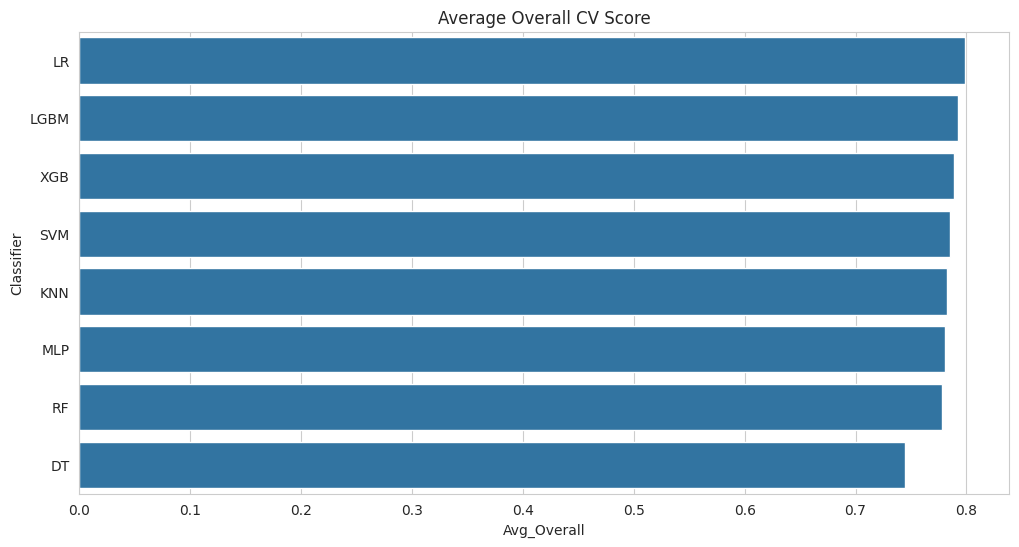

In [408]:
plt.figure(figsize=(12,6))
sns.barplot(data=results, x='Avg_Overall', y='Classifier')
plt.title('Average Overall CV Score')
plt.show()

In [409]:
lr = LogisticRegression()
params = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # Change set to list
    'tol': [0.1, 0.01, 0.001, 0.0001],      # Lists are used for tol and C
    'C': [10.0, 1.0, 0.1, 0.01]
}
clf = GridSearchCV(lr, params, cv=10)
clf.fit(X_train_scaled, y_train)
print('Best hyperparameter:', clf.best_params_)

Best hyperparameter: {'C': 1.0, 'penalty': 'l2', 'tol': 0.001}


Train Accuracy: 0.8338945005611672
Train F1-Score: 0.7771084337349398


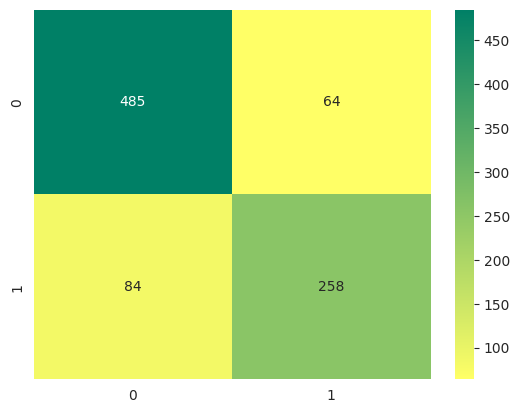

In [410]:
y_pred = clf.predict(X_train_scaled)
print(f'Train Accuracy: {accuracy_score(y_train, y_pred)}')
print(f'Train F1-Score: {f1_score(y_train, y_pred)}')
sns.heatmap(confusion_matrix(y_train, y_pred), fmt='.3g', annot=True, cmap='summer_r');

In [411]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       549
           1       0.80      0.75      0.78       342

    accuracy                           0.83       891
   macro avg       0.83      0.82      0.82       891
weighted avg       0.83      0.83      0.83       891



In [412]:
y_pred=clf.predict(X_test_scaled)
submission=pd.read_csv('gender_submission.csv')
submission['Survived']=y_pred
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
